In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda')

class ProbeClassifier(nn.Module):
    def __init__(self):
        super(ProbeClassifier, self).__init__()
        self.dense = nn.Linear(768 * 2, 768)
        self.norm = nn.BatchNorm1d(768)
        # self.dense1 = nn.Linear(768, 256)
        # self.norm1 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.2)
        self.out_proj = nn.Linear(768, 2)
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.dense(x)
        x = self.norm(x)
        # x = torch.tanh(x)
        # x = self.dense1(x)
        # x = self.norm1(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
import pickle
import torch
import numpy as np

with open("./train_attentions_4th.pt", "rb") as f:
    pt_data = torch.load(f)

label = [x[1] for x in pt_data]
pt_data = [x[0] for x in pt_data]

print("Before SMOTE:", np.bincount(label))
smote = SMOTE(sampling_strategy='auto', random_state=42)
pt_data, label = smote.fit_resample(pt_data, label)
print("After SMOTE:", np.bincount(label))

X_train, X_test, y_train, y_test = train_test_split(pt_data, label, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

print(y_train_tensor)
print(torch.sum(y_train_tensor).item()/len(y_train_tensor))
print((len(y_train_tensor) - torch.sum(y_train_tensor).item())/len(y_train_tensor))

# 创建训练和测试的Dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 创建DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Before SMOTE: [4163 4170]
After SMOTE: [4170 4170]
tensor([1, 1, 1,  ..., 1, 0, 0], device='cuda:0')
0.5013489208633094
0.49865107913669066


In [3]:
from transformers import RobertaConfig, RobertaForSequenceClassification
model = ProbeClassifier().to(device)

# config = RobertaConfig.from_pretrained('microsoft/codebert-base')
# config.num_labels = 1
# modelx = RobertaForSequenceClassification.from_pretrained('microsoft/codebert-base', config=config)

# source_parameters_dense = modelx.classifier.dense.state_dict()
# source_parameters_out_proj = modelx.classifier.out_proj.state_dict()

# model.dense.load_state_dict(source_parameters_dense)
# model.out_proj.load_state_dict(source_parameters_out_proj)

# for param_source, param_target in zip(modelx.classifier.dense.parameters(), model.dense.parameters()):
#     assert torch.equal(param_source, param_target)

In [ ]:

criterion = nn.BCEWithLogitsLoss()  # 对于二分类问题，这里假设标签是0和1
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model.eval()  # 设置模型为评估模式
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        outputs = model(data).squeeze()
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on test set: {accuracy * 100:.2f}%')

# 训练过程
model.train()
num_epochs = 50
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # 前向传播
        scores = model(data).squeeze()
        loss = criterion(scores, targets.float())

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 打印训练进度
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            total_loss = 0.0
            total_samples = 0
            with torch.no_grad():
                for data, targets in test_loader:
                    # 获取模型的预测结果
                    outputs = model(data).squeeze()

                    # 计算损失
                    loss = criterion(outputs, targets.float())

                    # 累积损失
                    total_loss += loss.item() * data.size(0)
                    total_samples += data.size(0)

            # 计算平均损失
            average_loss = total_loss / total_samples
            print(f"Average test loss: {average_loss:.4f}")

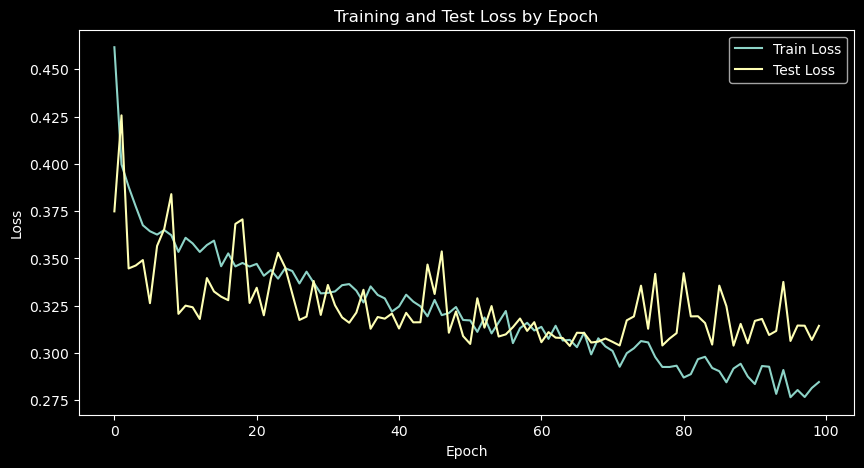

Epoch 1: Train Loss: 0.4617, Test Loss: 0.3749
Epoch 2: Train Loss: 0.3997, Test Loss: 0.4257
Epoch 3: Train Loss: 0.3879, Test Loss: 0.3447
Epoch 4: Train Loss: 0.3775, Test Loss: 0.3463
Epoch 5: Train Loss: 0.3676, Test Loss: 0.3492
Epoch 6: Train Loss: 0.3644, Test Loss: 0.3264
Epoch 7: Train Loss: 0.3626, Test Loss: 0.3566
Epoch 8: Train Loss: 0.3650, Test Loss: 0.3655
Epoch 9: Train Loss: 0.3623, Test Loss: 0.3840
Epoch 10: Train Loss: 0.3535, Test Loss: 0.3207
Epoch 11: Train Loss: 0.3609, Test Loss: 0.3250
Epoch 12: Train Loss: 0.3580, Test Loss: 0.3242
Epoch 13: Train Loss: 0.3534, Test Loss: 0.3180
Epoch 14: Train Loss: 0.3571, Test Loss: 0.3396
Epoch 15: Train Loss: 0.3594, Test Loss: 0.3325
Epoch 16: Train Loss: 0.3459, Test Loss: 0.3298
Epoch 17: Train Loss: 0.3527, Test Loss: 0.3279
Epoch 18: Train Loss: 0.3458, Test Loss: 0.3683
Epoch 19: Train Loss: 0.3476, Test Loss: 0.3707
Epoch 20: Train Loss: 0.3457, Test Loss: 0.3265
Epoch 21: Train Loss: 0.3471, Test Loss: 0.3345
E

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


criterion = nn.CrossEntropyLoss()  # 对于二分类问题，这里假设标签是0和1
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model.train()
num_epochs = 100

# 初始化损失跟踪列表
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    total_train_loss = 0
    total_train_samples = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # 前向传播
        scores = model(data).squeeze()
        loss = criterion(scores, targets)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 累积训练损失
        total_train_loss += loss.item() * data.size(0)
        total_train_samples += data.size(0)

    # 计算每个epoch的平均训练损失
    average_train_loss = total_train_loss / total_train_samples
    train_losses.append(average_train_loss)
    
    # 测试损失计算
    total_loss = 0.0
    total_samples = 0
    model.eval()  # 切换到评估模式
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data).squeeze()
            loss = criterion(outputs, targets)
            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)

    average_loss = total_loss / total_samples
    test_losses.append(average_loss)

    # 切换回训练模式
    model.train()

    # 绘制训练和测试损失
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss by Epoch')
    plt.legend()
    plt.show()

for i in range(num_epochs):
    print(f"Epoch {i+1}: Train Loss: {train_losses[i]:.4f}, Test Loss: {test_losses[i]:.4f}")


In [5]:
model.eval()  # 设置模型为评估模式
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        outputs = model(data)
        outputs = torch.softmax(outputs, dim=1)
        # predicted = torch.round(outputs)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
accuracy = correct / total
print(f'Accuracy of the model on test set: {accuracy * 100:.2f}%')

Accuracy of the model on test set: 86.93%


In [ ]:
torch.save(model.state_dict(), 'ProbeClassifier.pth')